# Kinetic energy equipartition

*Note: This notebook can be run locally by cloning the*
[Github repository](https://github.com/shirtsgroup/physical_validation).
*The notebook is located in* `doc/examples/kinetic_energy_equipartition.ipynb`. *Be aware
that probabilistic quantities such as error estimates based on bootstrapping
will differ when repeating the analysis.*

In [1]:
# enable plotting in notebook
%matplotlib notebook

The results imported here are results from example simulations, which are
the time series of the kinetic/potential energy, position and velocity stored in another Python file. In real-world usage, the results would
either come from the Python interface of the simulation package, from
flat files containing the results, or from package-specific parsers. See
[SimulationData](../simulation_data.rst) for more details.

In [2]:
from simulation_results import example_simulations

import physical_validation
import numpy as np

## Check solute from solvated simulation

`physical_validation` does not only allow to test the kinetic energy of the entire system, but also the kinetic energy of parts of the system, or how the kinetic energy is distributed within the molecules (translational, rotational and internal kinetic energy).

To demonstrate this check, we will first look at a simulation of a Trp-cage mini-protein. This simulation was performed in water, using a single thermostat connected to the entire system (solute and solvent). Since there is significantly more solvent than solute in typical solvated simulations, unphysical behavior of the solute might be hidden due to the large amount of solvent when looking at full-system properties. We will therefore look at the trajectory which was stripped from the water in post-processing to check the kinetic energy of the solute alone.

We will first load the results from the imported example simulations:

In [3]:
simulation = example_simulations.get(
    "Trp-cage, NPT at 300K and 1bar, protein trajectory only"
)

Next, we will create the object containing system information.
The single Trp-cage molecule consists of 304 atoms, and has 310 constrained bonds. The translational center of mass motion was removed during the simulation, while the rotation of the center of mass was not constrained.

The equipartition check does not only require information for the entire system, but also details about the atoms and the different molecules. We need to provide the mass of each atom in the system to allow the test to calculate the center of mass of each molecule at each step. We also need to provide the index of the first atom of each molecule, and the number of constraints of each molecule. In our case, the latter two quantities are an array with a single entry, because we operate on a single molecule. If we had, for example, two fully constrained water molecules in our system instead of the Trp-cage protein, the molecule index would read `np.array([0, 3])` (the first atom of the first water molecule has index 0, the first atom of the second water molecule has index 3), while the number of constraints per molecule would read `np.array([3, 3])` (3 constraints in each water molecule).

Here, we are loading these values from the example simulation data structure. In typical use, this information needs to be read from the simulation package: Through its Python interface if one is available, by the user otherwise.

In [4]:
system_data = physical_validation.data.SystemData(
    # Read system information from the example simulation
    natoms=simulation["natoms"],
    nconstraints=simulation["nconstraints"],
    ndof_reduction_tra=simulation["ndof_reduction_tra"],
    ndof_reduction_rot=simulation["ndof_reduction_rot"],
    mass=simulation["mass"],
    # We only have one molecule
    molecule_idx=np.array([0]),
    # The single molecule has all constraints of the system
    nconstraints_per_molecule=np.array([simulation["nconstraints"]]),
)

Next, we will create the ensemble information:

In [5]:
ensemble_data = physical_validation.data.EnsembleData(
    ensemble="NPT",
    natoms=simulation["natoms"],
    pressure=1.0,
    temperature=300.0,
)

Now we will create the simulation data objects which we will feed to the physical validation tests.

In [6]:
simulation_data = physical_validation.data.SimulationData(
    # Example simulations were performed using GROMACS
    units=physical_validation.data.UnitData.units("GROMACS"),
    system=system_data,
    ensemble=ensemble_data,
    # The equipartition test needs position and velocity trajectories    
    trajectory=physical_validation.data.TrajectoryData(
        position=simulation["position"],
        velocity=simulation["velocity"],
    )
)

The simulation was performed using a single thermostat connected to the entire system (solute and solvent). Since there is significantly more solvent than solute in typical solvated simulations, unphysical behavior of the solute might be hidden We are now analyzing the solute alone. 

We can now check the kinetic energy distribution of the solute. By default, the equipartition check will verify the distribution of the total, the translational, the rotational, and the internal kinetic energy. We are using `screen=True` to display a result plot on screen (see argument `filename` to print that same plot to file).

Equipartition: Testing group-wise kinetic energies (strict)
* total:
After equilibration, decorrelation and tail pruning, 90.60% (906 frames) of original Kinetic energy remain.


<IPython.core.display.Javascript object>


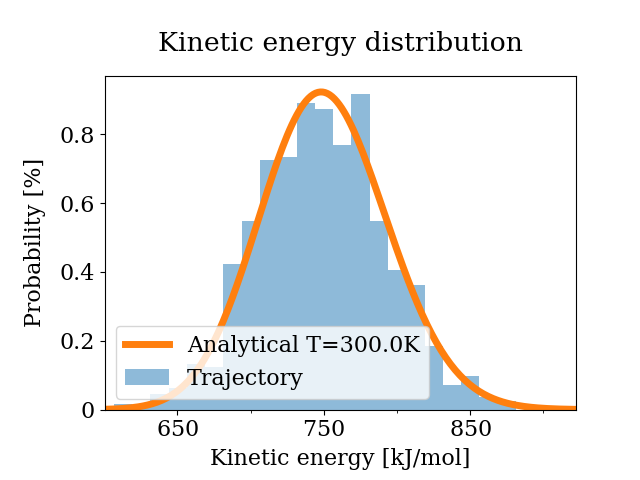

p = 0.19142
* translational:
After equilibration, decorrelation and tail pruning, 98.70% (987 frames) of original Kinetic energy remain.


<IPython.core.display.Javascript object>


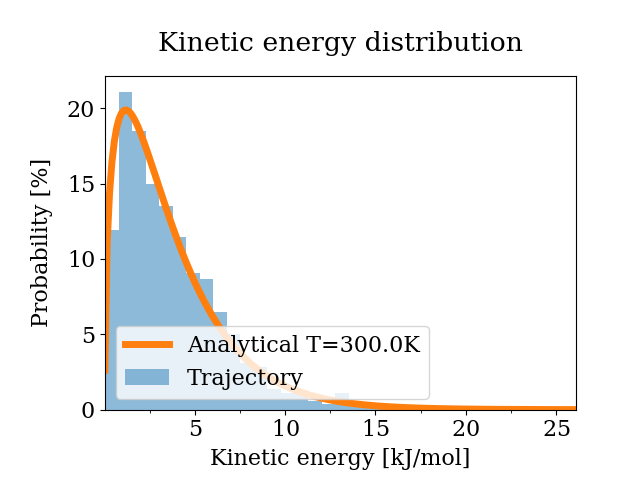

p = 0.222366
* rotational and internal:
After equilibration, decorrelation and tail pruning, 89.30% (893 frames) of original Kinetic energy remain.


<IPython.core.display.Javascript object>


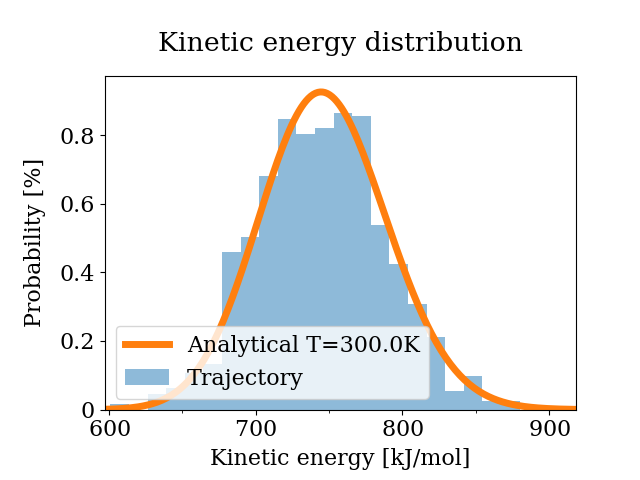

p = 0.214754
* rotational:
After equilibration, decorrelation and tail pruning, 100.00% (1000 frames) of original Kinetic energy remain.


<IPython.core.display.Javascript object>


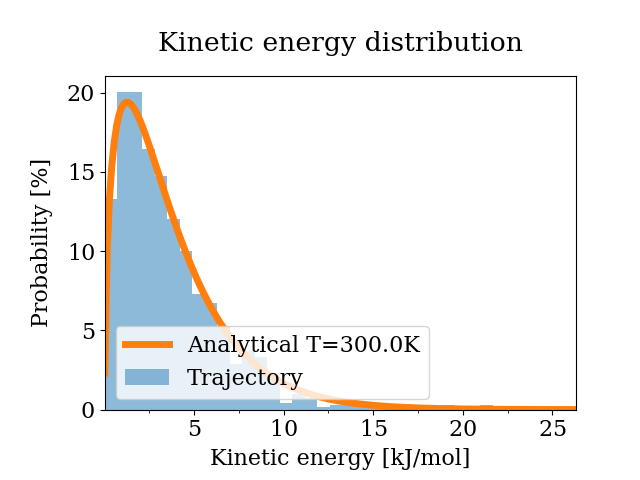

p = 0.387559
* internal:
After equilibration, decorrelation and tail pruning, 91.30% (913 frames) of original Kinetic energy remain.


<IPython.core.display.Javascript object>


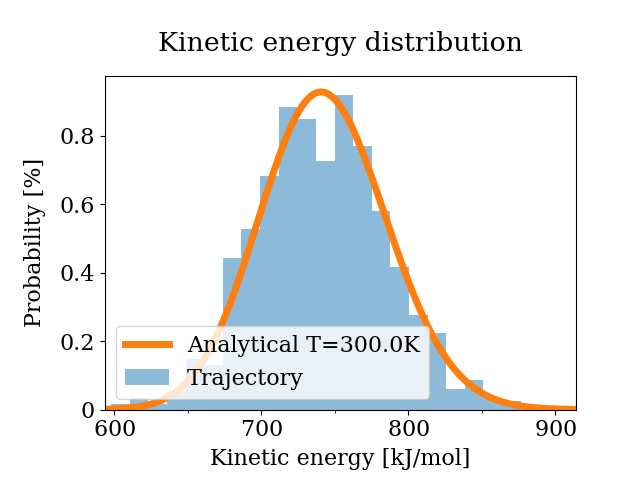

p = 0.137762


[0.19141994837327247,
 0.22236562034118057,
 0.21475378052598215,
 0.3875590890276527,
 0.13776199439893277]

In [7]:
physical_validation.kinetic_energy.equipartition(
    data=simulation_data, strict=True, screen=True
)

The `strict` test prints and returns p-values which indicate that the null hypothesis stands for all different kinetic energies. Commonly, one would consider a p-value of less than 0.05 (5% confidence interval) a reasonable cut-off. The printed figures confirm that the sampled and the analytical distributions are very similar in all cases.

We can therefore be confident that the full system temperature coupling does indeed lead to the solute sampling the correct kinetic energy distribution.

## Check gas phase simulations for correctness

As another example, we will now look at two simulations of octanol in gas phase at 298.15 K. Each simulation consisted of 512 non-interacting octanol molecules. One of the simulations was performed using molecular dynamics with velocity-rescale temperature coupling, while the other was performed using stochastic dynamics.

In [8]:
simulation_md = example_simulations.get(
    "512 octanol molecules in gas phase at 298K, MD with v-rescale"
)
simulation_sd = example_simulations.get(
    "512 octanol molecules in gas phase at 298K, SD"
)

The system consists of 512 united-atom 1-octanol molecules. Each (linear) molecule is made up of 10 atoms, with 9 constrained bonds between them. In both simulations, the translational center of mass motion was removed, while the rotational was unconstrained. The mass vector is a 512-fold repetition of the masses of a single octanol molecule. The molecule index starts at atom 0 and increases in increments of 10 until the last molecule which starts at atom 511x10 = 5110. The number of constraints per molecule is 9 for all molecules

In [9]:
num_molecules = 512
num_atoms_per_molecule = 10
num_constraints_per_molecule = num_atoms_per_molecule - 1

system_data = physical_validation.data.SystemData(
    # Read system information from the example simulation
    natoms=num_molecules * num_atoms_per_molecule,
    nconstraints=num_molecules * num_constraints_per_molecule,
    ndof_reduction_tra=3,
    ndof_reduction_rot=0,
    # np.tile repeats the single-molecule mass vector `num_molecules` times
    mass=np.tile(
        [
            1.008,
            15.9994,
            14.027,
            14.027,
            14.027,
            14.027,
            14.027,
            14.027,
            14.027,
            15.035,
        ],
        num_molecules,
    ),
    # The first atom of each molecule: [0, 10, 20, ..., 5110]
    molecule_idx=np.arange(
        0, num_molecules * num_atoms_per_molecule, num_atoms_per_molecule
    ),
    # Each molecule has nine constraints: [9, 9, ..., 9]
    nconstraints_per_molecule=num_constraints_per_molecule * np.ones(num_molecules),
)

The simulations were performed under NVT:

In [10]:
ensemble_data = physical_validation.data.EnsembleData(
    ensemble="NVT",
    natoms=num_molecules * num_atoms_per_molecule,
    volume=20,
    temperature=298.15,
)

We can now create the two simulation data objects:

In [11]:
simulation_data_md = physical_validation.data.SimulationData(
    # Example simulations were performed using GROMACS
    units=physical_validation.data.UnitData.units("GROMACS"),
    system=system_data,
    ensemble=ensemble_data,
    observables=physical_validation.data.ObservableData(
        kinetic_energy=simulation_md["kinetic energy"],
        potential_energy=simulation_md["potential energy"],
    ),
    trajectory=physical_validation.data.TrajectoryData(
        position=simulation_md["position"],
        velocity=simulation_md["velocity"],
    ),
)
simulation_data_sd = physical_validation.data.SimulationData(
    # Example simulations were performed using GROMACS
    units=physical_validation.data.UnitData.units("GROMACS"),
    system=system_data,
    ensemble=ensemble_data,
    observables=physical_validation.data.ObservableData(
        kinetic_energy=simulation_sd["kinetic energy"],
        potential_energy=simulation_sd["potential energy"],
    ),
    trajectory=physical_validation.data.TrajectoryData(
        position=simulation_sd["position"],
        velocity=simulation_sd["velocity"],
    ),
)

What is remarkable about these two simulations, is that they both seem to sample the correct full-system kinetic energy distribution:

In [12]:
physical_validation.kinetic_energy.distribution(data=simulation_data_md, strict=True)

After equilibration, decorrelation and tail pruning, 100.00% (76 frames) of original Kinetic energy remain.
Kinetic energy distribution check (strict)
Kolmogorov-Smirnov test result: p = 0.286917
Null hypothesis: Kinetic energy is Maxwell-Boltzmann distributed


0.28691678127130094

In [13]:
physical_validation.kinetic_energy.distribution(data=simulation_data_sd, strict=True)

After equilibration, decorrelation and tail pruning, 69.33% (52 frames) of original Kinetic energy remain.
Kinetic energy distribution check (strict)
Kolmogorov-Smirnov test result: p = 0.206281
Null hypothesis: Kinetic energy is Maxwell-Boltzmann distributed


0.20628105920809725

Yet their potential energy average is significantly different, at about 3 standard deviations of difference between the two estimates:

In [14]:
(simulation_data_md.observables.potential_energy.mean(), simulation_data_md.observables.potential_energy.std())

(8038.964400421053, 145.53838254074824)

In [15]:
(simulation_data_sd.observables.potential_energy.mean(), simulation_data_sd.observables.potential_energy.std())

(7579.539869773332, 169.56653568511697)

Running the equipartition check for both simulations sheds some light into what is happening:

In [16]:
physical_validation.kinetic_energy.equipartition(data=simulation_data_md, strict=False)

Equipartition: Testing group-wise kinetic energies (non-strict)
* total:
After equilibration, decorrelation and tail pruning, 100.00% (76 frames) of original Kinetic energy remain.
T(mu) = 298.51 +- 0.41 K
T(sigma) = 275.45 +- 21.05 K
* translational:
After equilibration, decorrelation and tail pruning, 39.47% (30 frames) of original Kinetic energy remain.
T(mu) = 251.01 +- 0.86 K
T(sigma) = 125.65 +- 17.20 K
* rotational and internal:
After equilibration, decorrelation and tail pruning, 100.00% (76 frames) of original Kinetic energy remain.
T(mu) = 305.70 +- 0.46 K
T(sigma) = 263.82 +- 23.94 K
* rotational:
After equilibration, decorrelation and tail pruning, 64.47% (49 frames) of original Kinetic energy remain.
T(mu) = 275.60 +- 0.80 K
T(sigma) = 153.42 +- 16.98 K
* internal:
After equilibration, decorrelation and tail pruning, 93.42% (71 frames) of original Kinetic energy remain.
T(mu) = 312.35 +- 0.41 K
T(sigma) = 219.04 +- 17.84 K


[(0.8877078177579152, 1.0785152946004155),
 (54.75807873647404, 10.026739798585906),
 (16.32772106740449, 1.43385330148231),
 (28.132986949338967, 8.525395451107745),
 (34.95911199352702, 4.434764508076646)]

The MD simulation does sample the correct full system kinetic energy, with both the mean and the variance within about a standard deviation of the true value. The internal temperature is, however, significantly too high (over 30 standard deviations above the expected value), while the temperature of the translational and rotational degrees of freedom are too low. Note that any deviation within about 2-3 standard deviations is usually considered as statistically insignificant.

In [17]:
physical_validation.kinetic_energy.equipartition(data=simulation_data_sd, strict=False)

Equipartition: Testing group-wise kinetic energies (non-strict)
* total:
After equilibration, decorrelation and tail pruning, 70.67% (53 frames) of original Kinetic energy remain.
T(mu) = 297.72 +- 0.47 K
T(sigma) = 278.28 +- 26.70 K
* translational:
After equilibration, decorrelation and tail pruning, 53.33% (40 frames) of original Kinetic energy remain.
T(mu) = 298.32 +- 1.63 K
T(sigma) = 282.62 +- 34.53 K
* rotational and internal:
After equilibration, decorrelation and tail pruning, 74.67% (56 frames) of original Kinetic energy remain.
T(mu) = 297.67 +- 0.48 K
T(sigma) = 244.46 +- 25.16 K
* rotational:
After equilibration, decorrelation and tail pruning, 97.33% (73 frames) of original Kinetic energy remain.
T(mu) = 296.16 +- 1.14 K
T(sigma) = 245.29 +- 23.93 K
* internal:
After equilibration, decorrelation and tail pruning, 84.00% (63 frames) of original Kinetic energy remain.
T(mu) = 298.05 +- 0.56 K
T(sigma) = 269.77 +- 21.29 K


[(0.9008763345265538, 0.7439987842383414),
 (0.10410349921537503, 0.4498521476007015),
 (0.9975145461349327, 2.1335398129869403),
 (1.7457884062564413, 2.2089826013916993),
 (0.17589254634896292, 1.3331699127717522)]

The SD simulation does, unlike the MD simulation, sample the right kinetic energy distribution for all degrees of freedom. Most crucially, it does sample the correct distribution for the internal degrees of freedom.

Since the molecules are in gas phase, i.e. non-interacting, all potential energy will come from intra-molecular interactions. Sampling the correct kinetic energy in the molecule-internal degree of freedom is hence key for a physically valid estimate of the potential energy. The MD simulation's elevated internal temperature explains why its potential energy estimate was significantly larger than the SD estimate.